# Data Analysis - Travel Destinations

In this notebook, we explore and construct a travel destination model: each travel destination is given different features in order to help the customer make a travel plan suitable to their likings.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import math
import statistics

## Obtaining a list of popular destinations
First we need a list of destinations. We choose the list of destinations of the 5 most popular airlines in the UK - British Airways (BA), EasyJet, Ryanair, Emirates and Etihad Airways. This data is public and can be retrived from Wikipedia: 

British Airways:
https://en.wikipedia.org/wiki/List_of_British_Airways_destinations,

Easyjet:
https://en.wikipedia.org/wiki/List_of_EasyJet_destinations,

Ryanair:
https://en.wikipedia.org/wiki/List_of_Ryanair_destinations,

Emirates:
https://en.wikipedia.org/wiki/List_of_Emirates_destinations,

Etihad Airways
https://en.wikipedia.org/wiki/List_of_Etihad_Airways_destinations.

In [115]:
# loading destinations datasets
ba_destinations = pd.read_csv('./travel_destinations_data/ba_destinations.csv')
ej_destinations = pd.read_csv('./travel_destinations_data/easyjet_destinations.csv')
ra_destinations = pd.read_csv('./travel_destinations_data/ryanair_destinations.csv')
em_destinations = pd.read_csv('./travel_destinations_data/em_destinations.csv')
et_destinations = pd.read_csv('./travel_destinations_data/et_destinations.csv')

In [116]:
# we drop all destinations that has been terminated (note: easyjet destinations excludes terminated)
ba_destinations.drop(index=ba_destinations[ba_destinations['Notes'] == 'Terminated'].index, inplace=True)
ra_destinations.drop(index=ra_destinations[ra_destinations['Notes'] == 'Terminated'].index, inplace=True)
em_destinations.drop(index=em_destinations[em_destinations['Notes'] == 'Terminated'].index, inplace=True)
et_destinations.drop(index=et_destinations[et_destinations['Notes'] == 'Terminated'].index, inplace=True)
ba_destinations.reset_index(drop=True)
ra_destinations.reset_index(drop=True)
em_destinations.reset_index(drop=True)
et_destinations.reset_index(drop=True)

# create a list of all countries and cities from the five airlines
all_destinations = []
for i in range(ba_destinations.shape[0]):
    all_destinations.append([
        ba_destinations.iloc[i]['Country'],
        ba_destinations.iloc[i]['City']
    ])

for i in range(ej_destinations.shape[0]):
    destination = [ej_destinations.iloc[i]['Country'], ej_destinations.iloc[i]['City']]
    if destination not in all_destinations:
        all_destinations.append(destination)
    else:
        continue

for i in range(ra_destinations.shape[0]):
    destination = [ra_destinations.iloc[i]['Country'], ra_destinations.iloc[i]['City']]
    if destination not in all_destinations:
        all_destinations.append(destination)
    else:
        continue
        
for i in range(em_destinations.shape[0]):
    destination = [em_destinations.iloc[i]['Country'], em_destinations.iloc[i]['City']]
    if destination not in all_destinations:
        all_destinations.append(destination)
    else:
        continue
        
for i in range(et_destinations.shape[0]):
    destination = [et_destinations.iloc[i]['Country'], et_destinations.iloc[i]['City']]
    if destination not in all_destinations:
        all_destinations.append(destination)
    else:
        continue

# converting our list of destinations into a dataframe
dest_df = pd.DataFrame(all_destinations)
dest_df.columns=['Country','City']
dest_df.sort_values(by=['Country', 'City'], ascending=[True, True], inplace=True)
dest_df.drop_duplicates(inplace=True)

# reorganise dataset
dest_df.reset_index(inplace=True)
dest_df.drop(columns='index', inplace=True)
number_of_destinations = len(dest_df)
print(f'Number of destinations: {number_of_destinations}')
pd.set_option('display.max_rows', number_of_destinations)
dest_df

Number of destinations: 425


,Country,City
0,Afghanistan,Kabul
1,Albania,Tirana
2,Algeria,Algiers
3,Angola,Luanda
4,Antigua and Barbuda,St. John's
5,Argentina,Buenos Aires
6,Armenia,Gyumri
7,Armenia,Yerevan
8,Australia,Brisbane
9,Australia,Melbourne


One important factor to take into account when recommanding travel plan is how far the destination is. This also affect flight prices and budget. Here we add the co-ordinates of each city using open data from World Cities Database: https://simplemaps.com/data/world-cities. 

In [117]:
# loading world cities coordinates database
coords_data = pd.read_csv('./travel_destinations_data/worldcities.csv')
coords_data.reset_index(inplace=True)
all_destinations = dest_df.values.tolist()
all_cities_coords=[]
# adding coordinates by iterating through the list
no_data_cities=[]
for country, city in all_destinations:
    filt = (coords_data['city_ascii'] == city) & (coords_data['country'] == country)
    series = coords_data.loc[filt]
    series.reset_index(inplace=True)
    try:
        # note: store location data as string
        city_coords = str(series.loc[0, 'lat']) + ', ' + str(series.loc[0, 'lng'])
    except KeyError:
        filt = (coords_data['city'] == city) & (coords_data['country'] == country)
        series = coords_data.loc[filt]
        series.reset_index(inplace=True)
        try:
            city_coords = str(series.loc[0, 'lat']) + ', ' + str(series.loc[0, 'lng'])
        except:
            no_data_cities.append(city)
            city_coords = 'unknown'
    all_cities_coords.append(city_coords)
print(no_data_cities)
dest_df['Location'] = all_cities_coords
# delete all rows with unknown coordinates
# these places are not popular enough to be on our list of destinations!
dest_df = dest_df[dest_df.Location != 'unknown']
dest_df.reset_index(inplace=True)
dest_df.drop(columns='index', inplace=True)
number_of_destinations = len(dest_df)
print(f'Number of destinations: {number_of_destinations}')
pd.set_option('display.max_rows', number_of_destinations)
dest_df.head(5)

['Banja Luka', 'Hong Kong', 'Prague', 'Billund', 'Punta Cana', 'Hurghada', 'Marsa Alam', 'Sharm El Sheikh', 'Bergerac', 'Calvi', 'Carcassonne', 'Chambéry', 'Dole', 'Figari', 'Lourdes Tarbes', 'Rodez', 'Saint-Malo Dinard', 'Cologne Bonn', 'Friedrichshafen', 'Hahn', 'Hanover', 'Karlsruhe Baden-Baden', 'Memmingen', 'Sylt', 'Corfu', 'Heraklion', 'Kefalonia', 'Mykonos', 'Mykonos Island', 'Preveza/Lefkada', 'Rhodes', 'Santorini', 'Zakynthos', 'Ahmedabad', 'Bengaluru', 'Kozhikode', 'Basra', 'Kerry', 'Knock', 'Isle of Man', 'Eilat', 'Alghero', 'Comiso', 'Cuneo', 'Lamezia Terme', 'Rimini', 'Trapani', 'Abidjan', 'Jersey', 'Aqaba', 'Pristina', 'Luxembourg City', 'Penang', 'Malé', 'Malta', 'Valletta Luqa', 'Mahébourg', 'Essaouira', 'Fez', 'Marrakesh', 'Nador', 'Ouarzazate', 'Oujda', 'Sialkot', 'Cebu', 'Clark', 'Terceira Island', 'Cluj', 'Timișoara', 'Vieux Fort', 'Mahé', 'Southampton Airport', 'Fuerteventura', 'Girona', 'Ibiza', 'Jerez de la Frontera', 'La Palma', 'Lanzarote', 'Menorca', 'OviedoGi

/home/sihao/anaconda3/lib/python3.7/site-packages/pandas/core/frame.py:3997: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


,Country,City,Location
0,Afghanistan,Kabul,"34.5167, 69.1833"
1,Albania,Tirana,"41.3275, 19.8189"
2,Algeria,Algiers,"36.7631, 3.0506"
3,Angola,Luanda,"-8.8383, 13.2344"
4,Antigua and Barbuda,St. John's,"17.118, -61.85"


## Plotting Travel Destinations on a World Map
Please note: running this section requires Basemap installed under current virtual environment (if any).

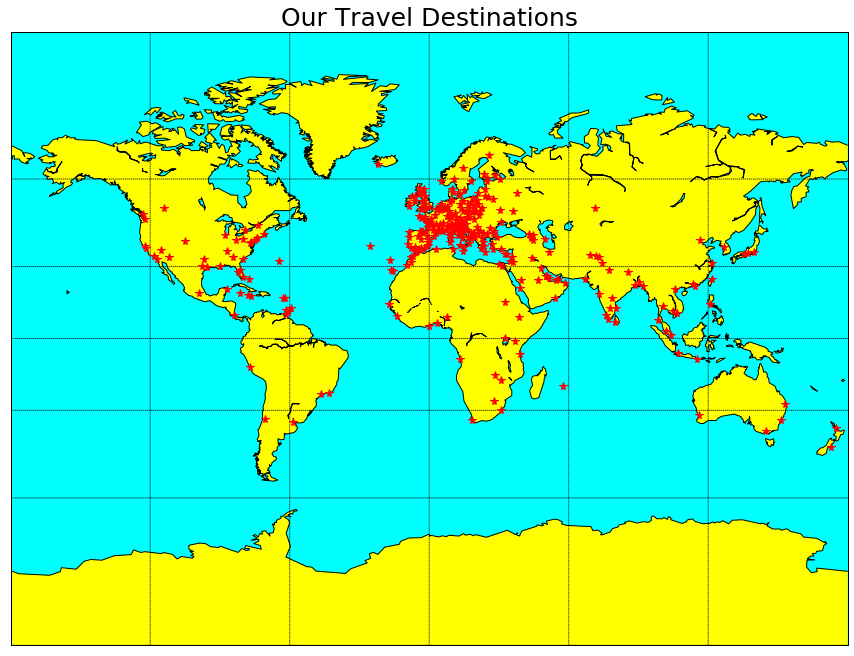

In [118]:
from mpl_toolkits.basemap import Basemap
plt.figure(figsize=(15, 20))
m = Basemap(projection='mill',llcrnrlat=-90,urcrnrlat=90,\
            llcrnrlon=-180,urcrnrlon=180,resolution='c')
m.drawcoastlines()
m.fillcontinents(color='yellow', lake_color='aqua')
m.drawparallels(np.arange(-90., 91.,30.))
m.drawmeridians(np.arange(-180., 181.,60.))
m.drawmapboundary(fill_color='aqua')
plt.title("Our Travel Destinations", size=25)
dest_to_plot = dest_df.values.tolist()
for i in dest_to_plot:
    lat, lng = i[2].split(', ')
    x, y = m(float(lng), float(lat))  # idk why but Basemap takes in latitude first
    m.plot(x, y, '*', color='red', markersize=8)
plt.show()

## Adding features to the destinations
There are many things people consider when choosing a holiday destination. Here we select a few popular factors people usually take into cosideration: 

*Cost*

*History and Culture*

*Water view*

*Mountain view*

*Quietness of the destination*

*Nightlife and Entertainment*


### Cost
We use cost-of-living index to assign each destination with a 'Cost' feature value. This index was developed by Russian economist A. A. Konüs and measures differences in the price of goods and services, and allows for substitutions with other items as prices vary. (Source: Wikipedia)
As different cities in a country has slightly different cost-of-living, we first try to assign the'Cost' feature using the cost-of-living index of indicidual city, then we fill the unassigned destination with the cost-of-living index of their respective country. It is worth noting that the calculation of the index is done in the same way in cities or countries hence they are comparable.
Source: https://www.numbeo.com/cost-of-living/rankings.jsp; https://www.numbeo.com/cost-of-living/rankings_by_country.jsp. Data retrived 19 Aug 2020.

In [119]:
all_destinations = dest_df.values.tolist()
# loading the public datasets from numbeo
coi_by_city = pd.read_csv('./travel_destinations_data/cost_of_living_index_by_cities_2020.csv')
coi_by_country = pd.read_csv('./travel_destinations_data/cost_of_living_index_by_country_2020.csv')
all_coi = []
no_data_countries = []
for item in all_destinations:
    filt = coi_by_city.City.str.contains(pat=item[1])
    series = coi_by_city.loc[filt]
    series.reset_index(inplace=True)
    try:
        coi = series.loc[0, 'Cost of Living Index']
    except KeyError:
        filt2 = coi_by_country.Country.str.contains(pat=item[0])
        series2 = coi_by_country.loc[filt2]
        series2.reset_index(inplace=True)
        try:
            coi = series2.loc[0, 'Cost of Living Index']
        except KeyError:
            no_data_countries.append(item[0])
            coi = 'unknown'
    all_coi.append(coi)

# we had to abandon the destination with cost data
print('Countries with no data:', no_data_countries)
len(all_coi)

Countries with no data: ['Angola', 'Antigua and Barbuda', 'Cayman Islands', 'Gibraltar', 'Grenada', 'Guinea', 'Saint Kitts and Nevis', 'Senegal', 'Sudan', 'Zambia']


330

To make sure all features are in a suitable scale, we need to normalise the values. Here we define a helper function to return the feature value between 0 and 100. In some cases where there are outliers too high, it might be useful to use a sigmoid transformation on data.

In [120]:
def normalise_feature(max_val, min_val, val):
    if type(val) != str:
        return (val - min_val) / (max_val - min_val) * 100
    else:
        return 'unknown'
def sigmoid(c1, c2, x):
    return 1/(1+(math.exp(-(x-c2))))

In [121]:
# calculate normalised cost
max_cost = max([i for i in all_coi if not isinstance(i, str)])
min_cost = min([i for i in all_coi if not isinstance(i, str)])
all_coi_normalised = []
for val in all_coi:
    all_coi_normalised.append(normalise_feature(max_cost, min_cost, val))
# updating dataframe
dest_df['Cost'] = all_coi_normalised
# reorganise
dest_df = dest_df[dest_df.Cost != 'unknown']
dest_df.reset_index(inplace=True)
dest_df.drop(columns='index', inplace=True)
number_of_destinations = len(dest_df)
print(f'Number of destinations: {number_of_destinations}')
pd.set_option('display.max_rows', number_of_destinations)
dest_df

Number of destinations: 320


/home/sihao/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


,Country,City,Location,Cost
0,Afghanistan,Kabul,"34.5167, 69.1833",6.45769
1,Albania,Tirana,"41.3275, 19.8189",18.1116
2,Algeria,Algiers,"36.7631, 3.0506",10.6279
3,Argentina,Buenos Aires,"-34.6025, -58.3975",11.268
4,Armenia,Gyumri,"40.7894, 43.8475",13.0472
5,Armenia,Yerevan,"40.1812, 44.5136",13.2825
6,Australia,Brisbane,"-27.455, 153.0351",52.6499
7,Australia,Melbourne,"-37.82, 144.975",50.7484
8,Australia,Perth,"-31.955, 115.84",53.2241
9,Australia,Sydney,"-33.92, 151.1852",59.1923


### Culture and History
It is hard to find a way to quantise how much culture or history a city is. Here we use the UNESCO data of World Heritage Convention heritage sites to help us establish a scale - in general, an area with more cultural heritage is more likely to be considered 'cultured' by tourist. However, please note that strictly speaking this is very discreet way of measuring and some people may consider areas with few heritage 'cultured' and vice versa.

Data retrived from https://www.kaggle.com/ujwalkandi/notebook?select=whc-sites-2019.csv on 20 Aug 2020.

In [122]:
# loading World Heritage Sites data
whc_data = pd.read_csv('./travel_destinations_data/whc-sites-2019.csv')
whc_cultural = whc_data[whc_data.category != 'Natural']
print(f'There are {len(whc_cultural)} cultural/mixed world heritages.')
# we extract the coordinates of the WHC sites
whc_coords = []
for i in range(len(whc_cultural)):
    lng, lat = whc_cultural.iloc[i]['longitude'], whc_cultural.iloc[i]['latitude']
    whc_coords.append([lng, lat])

There are 908 cultural/mixed world heritages.


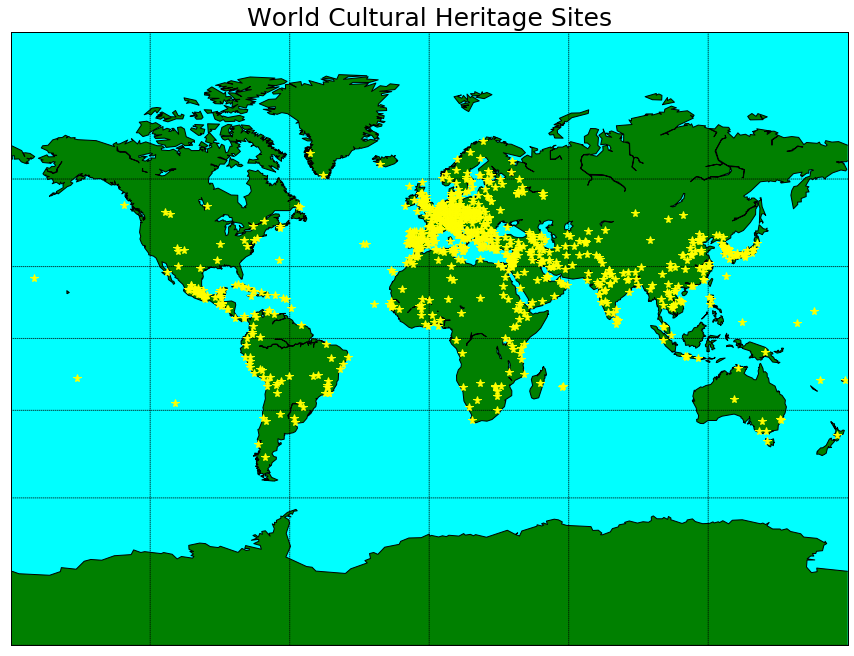

In [123]:
# we can see these sites on a world map
plt.figure(figsize=(15, 20))
m = Basemap(projection='mill',llcrnrlat=-90,urcrnrlat=90,\
            llcrnrlon=-180,urcrnrlon=180,resolution='c')
m.drawcoastlines()
m.fillcontinents(color='green', lake_color='aqua')
m.drawparallels(np.arange(-90., 91.,30.))
m.drawmeridians(np.arange(-180., 181.,60.))
m.drawmapboundary(fill_color='aqua')
plt.title("World Cultural Heritage Sites", size=25)
for i in whc_coords:
    lat, lng = i[1], i[0]
    x, y = m(float(lng), float(lat))  # idk why but Basemap takes in latitude first
    m.plot(x, y, '*', color='yellow', markersize=8)
plt.show()

In [124]:
# devise an algorithm to determine how many sites are in proximity to our destinations
all_destinations = dest_df.values.tolist()
all_nearby_sites = []
for i in all_destinations:
    lat, lng = i[2].split(', ')
    lat, lng = float(lat), float(lng)
# an approximation for 1 degree of longitude = cos(latitude)*degree length of longitude at the equator.
# 1 degree equals 69 miles on the equator. We use this as a standard range.
    lat_upper, lat_lower = lat + 1, lat - 1
    lng_upper, lng_lower = lng + 1/math.cos(math.pi/180*lat), lng - 1/math.cos(math.pi/180*lat)
    nearby_sites = 0
    for j in whc_coords:
        if j[0] > lng_lower and j[0] < lng_upper and j[1] > lat_lower and j[1] < lat_upper:
            nearby_sites += 1
    all_nearby_sites.append(nearby_sites)
# we discovered that a normalised transform on this data will have very high variance as there are some outliers
med_num_sites = statistics.median(all_nearby_sites)
print(f'The median number of sites around each city is {med_num_sites}.')
# here we use a sigmoid transform to counter the outliers
all_nearby_sites_sigmoid = []
for val in all_nearby_sites:
    all_nearby_sites_sigmoid.append(sigmoid(1, med_num_sites, val)*100)
# updating dataframe
dest_df['History_and_Culture'] = all_nearby_sites_sigmoid
# reorganise
dest_df = dest_df[dest_df.History_and_Culture != 'unknown']
dest_df.reset_index(inplace=True)
dest_df.drop(columns='index', inplace=True)
number_of_destinations = len(dest_df)
print(f'Number of destinations: {number_of_destinations}')
pd.set_option('display.max_rows', number_of_destinations)
dest_df

The median number of sites around each city is 2.0.
Number of destinations: 320


/home/sihao/anaconda3/lib/python3.7/site-packages/pandas/core/ops/array_ops.py:253: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  res_values = method(rvalues)


,Country,City,Location,Cost,History_and_Culture
0,Afghanistan,Kabul,"34.5167, 69.1833",6.45769,11.920292
1,Albania,Tirana,"41.3275, 19.8189",18.1116,26.894142
2,Algeria,Algiers,"36.7631, 3.0506",10.6279,50.000000
3,Argentina,Buenos Aires,"-34.6025, -58.3975",11.268,26.894142
4,Armenia,Gyumri,"40.7894, 43.8475",13.0472,88.079708
5,Armenia,Yerevan,"40.1812, 44.5136",13.2825,88.079708
6,Australia,Brisbane,"-27.455, 153.0351",52.6499,11.920292
7,Australia,Melbourne,"-37.82, 144.975",50.7484,26.894142
8,Australia,Perth,"-31.955, 115.84",53.2241,11.920292
9,Australia,Sydney,"-33.92, 151.1852",59.1923,50.000000


### Nature
Nature is an important factor people take into consideration. In general people go to the seaside for holidays or mountains for a hike. We construct two features: sea view and mountain view.
#### Water view
This can be rated by a city's distance to open water. The coastline coordinates can be extracted from Basemap's .drawcoastline() method, and distance is calculated in miles.
Note: the higher the map resolution, the longer it takes to process and the more accurate data will be. Resolution can take values 'c'(crude), 'l'(low), 'i'(intermediate), 'h'(high) and 'f'(Full).
To process high definition coastline, it takes 15 min 34 secs on Intel i7-8565U.

100%|██████████| 1162763/1162763 [00:02<00:00, 390123.78it/s]


1162763


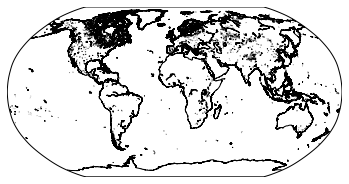

In [93]:
m = Basemap(projection='robin',lon_0=0,resolution='h')
coast = m.drawcoastlines()
coordinates = np.vstack(coast.get_segments())
coordinates = m(coordinates[:,0],coordinates[:,1],inverse=True)
coast_coordinates = []
# extract coastal coordinates data from Basemap
from tqdm import tqdm
for i in tqdm(range(len(coordinates[1]))):
    # lng, lat
    coast_coordinates.append([coordinates[0][i], coordinates[1][i]])
print(len(coast_coordinates))
# a helper function for calculating distance to open water
def coastal_distance(lng, lat, coast_coordinates):
    min_distance = 99999999
    for i in range(len(coast_coordinates)):
        distance = math.sqrt((((lng - coast_coordinates[i][0]) * (1/math.cos(math.pi/180*lat)))*69)**2 + ((lat - coast_coordinates[i][1])*69)**2)
        if distance < min_distance:
                    min_distance = distance
    return min_distance

In [94]:
all_destinations = dest_df.values.tolist()
all_distance_to_coast = []
for i in tqdm(all_destinations):
    lat, lng = i[2].split(', ')
    lat, lng = float(lat), float(lng)
    all_distance_to_coast.append(coastal_distance(lng, lat, coast_coordinates))

100%|██████████| 320/320 [15:34<00:00,  2.92s/it]


In [125]:
all_coast_score = []
for distance in all_distance_to_coast:
    if distance < 10:
        all_coast_score.append(100)
    else:
        all_coast_score.append(0)
# updating dataframe
dest_df['Open_Water'] = all_coast_score
# reorganise
dest_df = dest_df[dest_df.Open_Water != 'unknown']
dest_df.reset_index(inplace=True)
dest_df.drop(columns='index', inplace=True)
number_of_destinations = len(dest_df)
print(f'Number of destinations: {number_of_destinations}')
pd.set_option('display.max_rows', number_of_destinations)
dest_df

Number of destinations: 320


/home/sihao/anaconda3/lib/python3.7/site-packages/pandas/core/ops/array_ops.py:253: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  res_values = method(rvalues)


,Country,City,Location,Cost,History_and_Culture,Open_Water
0,Afghanistan,Kabul,"34.5167, 69.1833",6.45769,11.920292,0
1,Albania,Tirana,"41.3275, 19.8189",18.1116,26.894142,0
2,Algeria,Algiers,"36.7631, 3.0506",10.6279,50.000000,100
3,Argentina,Buenos Aires,"-34.6025, -58.3975",11.268,26.894142,100
4,Armenia,Gyumri,"40.7894, 43.8475",13.0472,88.079708,0
5,Armenia,Yerevan,"40.1812, 44.5136",13.2825,88.079708,0
6,Australia,Brisbane,"-27.455, 153.0351",52.6499,11.920292,100
7,Australia,Melbourne,"-37.82, 144.975",50.7484,26.894142,100
8,Australia,Perth,"-31.955, 115.84",53.2241,11.920292,100
9,Australia,Sydney,"-33.92, 151.1852",59.1923,50.000000,100


#### Mountain view
Here we use the Jawg Maps Elevation API enquire (inquire?) altitude of the destination. 
Documentations and Terms can be found at:
https://www.jawg.io/docs/apidocs/elevation/#elevation-values.

Note: running this cell requires internet access. JAWG allows up to 10,000 elevation enquiries per month for free but you should get your API key and support their business!

In [143]:
def generate_5_coords(centre_coords):
    # this function generates 4 geographic coordinates 
    # to the north, south, west and east of the centre
    # at a distance of 34.5 miles (0.5 degree at equator)
    centre_lat, centre_lng = centre_coords.split(', ')
    centre_lat, centre_lng = float(centre_lat), float(centre_lng)
    east_lat, east_lng = centre_lat, centre_lng + 0.5/math.cos(math.pi/180*centre_lat)
    west_lat, west_lng = centre_lat, centre_lng - 0.5/math.cos(math.pi/180*centre_lat)
    north_lat, north_lng = centre_lat + 1, centre_lng
    south_lat, south_lng = centre_lat - 1, centre_lng
    ewcns = [str(east_lat) + ',' + str(east_lng),
          str(west_lat) + ',' + str(west_lng), 
          str(centre_lat) + ',' + str(centre_lng),  
          str(north_lat) + ',' + str(north_lng),
          str(south_lat) + ',' + str(south_lng)]
    return '|'.join(ewcns)

In [139]:
from tqdm import tqdm
import time
import requests
import urllib
all_destinations = dest_df.values.tolist()
token = 'IEd8fdx0NyULtxyMGrHk8OkOkuz1zEqe5XJhGqpXj8sD1eWtS1A2SxJri2lNm3Oq'
# getting altitudes
all_altitude_differences=[]
for destination in tqdm(all_destinations):
    five_elevations = []
    coordinates = destination[2]
    five_coords = generate_5_coords(coordinates)
    results = requests.get('https://api.jawg.io/elevations?locations={}&access-token={}'.format(five_coords, token))
    results = results.json()
    for i in range(len(results)):
        five_elevations.append(results[i]['elevation'])
        max_elevation_difference = (max(five_elevations) - min(five_elevations))
    time.sleep(2)
    all_altitude_differences.append(max_elevation_difference)
    print(f'Currently processing {destination[1]}, maximum altitude difference {max_elevation_difference} meters')
print('All data retrived.')


  0%|          | 1/320 [00:02<11:34,  2.18s/it]

Currently processing Kabul, maximum altitude difference 1549.5 meters



  1%|          | 2/320 [00:04<11:38,  2.20s/it]

Currently processing Tirana, maximum altitude difference 1355.5 meters



  1%|          | 3/320 [00:06<11:35,  2.20s/it]

Currently processing Algiers, maximum altitude difference 746.4004 meters



  1%|▏         | 4/320 [00:08<11:33,  2.19s/it]

Currently processing Buenos Aires, maximum altitude difference 37.600586 meters



  2%|▏         | 5/320 [00:11<11:33,  2.20s/it]

Currently processing Gyumri, maximum altitude difference 857.5996000000002 meters



  2%|▏         | 6/320 [00:13<11:30,  2.20s/it]

Currently processing Yerevan, maximum altitude difference 1241.2998 meters



  2%|▏         | 7/320 [00:15<11:24,  2.19s/it]

Currently processing Brisbane, maximum altitude difference 203.2998 meters



  2%|▎         | 8/320 [00:17<11:19,  2.18s/it]

Currently processing Melbourne, maximum altitude difference 197.10059 meters



  3%|▎         | 9/320 [00:19<11:18,  2.18s/it]

Currently processing Perth, maximum altitude difference 276.5 meters



  3%|▎         | 10/320 [00:21<11:17,  2.19s/it]

Currently processing Sydney, maximum altitude difference 285.9004 meters



  3%|▎         | 11/320 [00:24<11:15,  2.19s/it]

Currently processing Graz, maximum altitude difference 611.6992 meters



  4%|▍         | 12/320 [00:26<11:21,  2.21s/it]

Currently processing Innsbruck, maximum altitude difference 1717.2002 meters



  4%|▍         | 13/320 [00:28<11:19,  2.21s/it]

Currently processing Klagenfurt, maximum altitude difference 668.1006 meters



  4%|▍         | 14/320 [00:30<11:20,  2.22s/it]

Currently processing Salzburg, maximum altitude difference 2023.0000000000002 meters



  5%|▍         | 15/320 [00:33<11:14,  2.21s/it]

Currently processing Vienna, maximum altitude difference 147.0 meters



  5%|▌         | 16/320 [00:35<11:14,  2.22s/it]

Currently processing Baku, maximum altitude difference 285.9004 meters



  5%|▌         | 17/320 [00:37<11:13,  2.22s/it]

Currently processing Nassau, maximum altitude difference 0.0 meters



  6%|▌         | 18/320 [00:39<11:09,  2.22s/it]

Currently processing Manama, maximum altitude difference 11.0 meters



  6%|▌         | 19/320 [00:42<11:23,  2.27s/it]

Currently processing Chittagong, maximum altitude difference 179.0 meters



  6%|▋         | 20/320 [00:44<11:13,  2.25s/it]

Currently processing Dhaka, maximum altitude difference 15.100586 meters



  7%|▋         | 21/320 [00:46<11:06,  2.23s/it]

Currently processing Bridgetown, maximum altitude difference 13.0 meters



  7%|▋         | 22/320 [00:48<11:00,  2.22s/it]

Currently processing Minsk, maximum altitude difference 74.10059000000001 meters



  7%|▋         | 23/320 [00:50<10:51,  2.19s/it]

Currently processing Brussels, maximum altitude difference 255.599609375 meters



  8%|▊         | 24/320 [00:52<10:47,  2.19s/it]

Currently processing Charleroi, maximum altitude difference 238.200195 meters



  8%|▊         | 25/320 [00:55<10:44,  2.19s/it]

Currently processing Hamilton, maximum altitude difference 28.100586 meters



  8%|▊         | 26/320 [00:57<10:39,  2.17s/it]

Currently processing Rio de Janeiro, maximum altitude difference 456.1006 meters



  8%|▊         | 27/320 [00:59<10:40,  2.18s/it]

Currently processing São Paulo, maximum altitude difference 919.7002 meters



  9%|▉         | 28/320 [01:01<10:41,  2.20s/it]

Currently processing Burgas, maximum altitude difference 287.4004 meters



  9%|▉         | 29/320 [01:03<10:43,  2.21s/it]

Currently processing Plovdiv, maximum altitude difference 691.5 meters



  9%|▉         | 30/320 [01:06<10:40,  2.21s/it]

Currently processing Sofia, maximum altitude difference 1324.00001 meters



 10%|▉         | 31/320 [01:08<10:37,  2.21s/it]

Currently processing Varna, maximum altitude difference 332.7002 meters



 10%|█         | 32/320 [01:10<10:33,  2.20s/it]

Currently processing Phnom Penh, maximum altitude difference 60.399414 meters



 10%|█         | 33/320 [01:12<10:28,  2.19s/it]

Currently processing Calgary, maximum altitude difference 704.5 meters



 11%|█         | 34/320 [01:14<10:26,  2.19s/it]

Currently processing Montreal, maximum altitude difference 420.1006 meters



 11%|█         | 35/320 [01:17<10:24,  2.19s/it]

Currently processing Toronto, maximum altitude difference 307.2998 meters



 11%|█▏        | 36/320 [01:19<10:19,  2.18s/it]

Currently processing Vancouver, maximum altitude difference 1244.1006 meters



 12%|█▏        | 37/320 [01:21<10:19,  2.19s/it]

Currently processing Santiago, maximum altitude difference 2924.7002 meters



 12%|█▏        | 38/320 [01:23<10:16,  2.19s/it]

Currently processing Beijing, maximum altitude difference 1219.7002094 meters



 12%|█▏        | 39/320 [01:25<10:12,  2.18s/it]

Currently processing Guangzhou, maximum altitude difference 71.100586 meters



 12%|█▎        | 40/320 [01:27<10:07,  2.17s/it]

Currently processing Shanghai, maximum altitude difference 8.799805 meters



 13%|█▎        | 41/320 [01:30<10:04,  2.17s/it]

Currently processing San Jose, maximum altitude difference 1146.4004 meters



 13%|█▎        | 42/320 [01:32<10:03,  2.17s/it]

Currently processing Dubrovnik, maximum altitude difference 1247.7998 meters



 13%|█▎        | 43/320 [01:34<09:59,  2.16s/it]

Currently processing Pula, maximum altitude difference 76.100586 meters



 14%|█▍        | 44/320 [01:36<09:58,  2.17s/it]

Currently processing Rijeka, maximum altitude difference 1261.9004 meters



 14%|█▍        | 45/320 [01:38<09:56,  2.17s/it]

Currently processing Split, maximum altitude difference 750.2998 meters



 14%|█▍        | 46/320 [01:40<09:54,  2.17s/it]

Currently processing Zadar, maximum altitude difference 534.0 meters



 15%|█▍        | 47/320 [01:43<09:53,  2.17s/it]

Currently processing Zagreb, maximum altitude difference 792.800795 meters



 15%|█▌        | 48/320 [01:45<09:47,  2.16s/it]

Currently processing Larnaca, maximum altitude difference 1080.6006 meters



 15%|█▌        | 49/320 [01:47<09:44,  2.16s/it]

Currently processing Paphos, maximum altitude difference 426.2002 meters



 16%|█▌        | 50/320 [01:49<09:43,  2.16s/it]

Currently processing Prague, maximum altitude difference 204.2002 meters



 16%|█▌        | 51/320 [01:51<09:47,  2.18s/it]

Currently processing Brno, maximum altitude difference 463.1006 meters



 16%|█▋        | 52/320 [01:54<09:45,  2.19s/it]

Currently processing Ostrava, maximum altitude difference 436.29981 meters



 17%|█▋        | 53/320 [01:56<09:42,  2.18s/it]

Currently processing Pardubice, maximum altitude difference 276.5 meters



 17%|█▋        | 54/320 [01:58<09:35,  2.16s/it]

Currently processing Aalborg, maximum altitude difference 26.600586 meters



 17%|█▋        | 55/320 [02:00<09:29,  2.15s/it]

Currently processing Aarhus, maximum altitude difference 95.299805 meters



 18%|█▊        | 56/320 [02:02<09:29,  2.16s/it]

Currently processing Copenhagen, maximum altitude difference 26.100586 meters



 18%|█▊        | 57/320 [02:04<09:34,  2.19s/it]

Currently processing Alexandria, maximum altitude difference 151.2002 meters



 18%|█▊        | 58/320 [02:07<09:30,  2.18s/it]

Currently processing Cairo, maximum altitude difference 254.7998047 meters



 18%|█▊        | 59/320 [02:09<09:31,  2.19s/it]

Currently processing Tallinn, maximum altitude difference 89.299805 meters



 19%|█▉        | 60/320 [02:11<09:33,  2.21s/it]

Currently processing Addis Ababa, maximum altitude difference 774.2002 meters



 19%|█▉        | 61/320 [02:13<09:29,  2.20s/it]

Currently processing Helsinki, maximum altitude difference 88.0 meters



 19%|█▉        | 62/320 [02:15<09:28,  2.20s/it]

Currently processing Lappeenranta, maximum altitude difference 112.200195 meters



 20%|█▉        | 63/320 [02:18<09:22,  2.19s/it]

Currently processing Rovaniemi, maximum altitude difference 149.40039 meters



 20%|██        | 64/320 [02:20<09:16,  2.18s/it]

Currently processing Tampere, maximum altitude difference 81.700195 meters



 20%|██        | 65/320 [02:22<09:17,  2.19s/it]

Currently processing Ajaccio, maximum altitude difference 63.600586 meters



 21%|██        | 66/320 [02:24<09:15,  2.19s/it]

Currently processing Bastia, maximum altitude difference 33.5 meters



 21%|██        | 67/320 [02:26<09:11,  2.18s/it]

Currently processing Biarritz, maximum altitude difference 441.9004 meters



 21%|██▏       | 68/320 [02:28<09:08,  2.18s/it]

Currently processing Bordeaux, maximum altitude difference 93.0 meters



 22%|██▏       | 69/320 [02:31<09:15,  2.21s/it]

Currently processing Brest, maximum altitude difference 234.299809375 meters



 22%|██▏       | 70/320 [02:33<09:10,  2.20s/it]

Currently processing Brive-la-Gaillarde, maximum altitude difference 528.300795 meters



 22%|██▏       | 71/320 [02:35<09:06,  2.20s/it]

Currently processing Béziers, maximum altitude difference 898.1006 meters



 22%|██▎       | 72/320 [02:37<09:06,  2.20s/it]

Currently processing Clermont-Ferrand, maximum altitude difference 922.2002 meters



 23%|██▎       | 73/320 [02:40<09:06,  2.21s/it]

Currently processing Grenoble, maximum altitude difference 1116.8008 meters



 23%|██▎       | 74/320 [02:42<08:59,  2.19s/it]

Currently processing La Rochelle, maximum altitude difference 80.40039 meters



 23%|██▎       | 75/320 [02:44<08:54,  2.18s/it]

Currently processing Lille, maximum altitude difference 71.700195 meters



 24%|██▍       | 76/320 [02:46<08:53,  2.19s/it]

Currently processing Limoges, maximum altitude difference 607.599605 meters



 24%|██▍       | 77/320 [02:48<08:50,  2.19s/it]

Currently processing Lorient, maximum altitude difference 66.90039 meters



 24%|██▍       | 78/320 [02:50<08:49,  2.19s/it]

Currently processing Lyon, maximum altitude difference 470.0 meters



 25%|██▍       | 79/320 [02:53<08:45,  2.18s/it]

Currently processing Marseille, maximum altitude difference 599.9004 meters



 25%|██▌       | 80/320 [02:55<08:46,  2.20s/it]

Currently processing Montpellier, maximum altitude difference 1078.1006 meters



 25%|██▌       | 81/320 [02:57<08:43,  2.19s/it]

Currently processing Nantes, maximum altitude difference 102.90039 meters



 26%|██▌       | 82/320 [02:59<08:42,  2.19s/it]

Currently processing Nice, maximum altitude difference 1265.5 meters



 26%|██▌       | 83/320 [03:01<08:37,  2.18s/it]

Currently processing Nîmes, maximum altitude difference 1081.5 meters



 26%|██▋       | 84/320 [03:04<08:34,  2.18s/it]

Currently processing Paris, maximum altitude difference 100.20019499999998 meters



 27%|██▋       | 85/320 [03:06<08:33,  2.18s/it]

Currently processing Perpignan, maximum altitude difference 1505.1006 meters



 27%|██▋       | 86/320 [03:08<08:28,  2.18s/it]

Currently processing Poitiers, maximum altitude difference 145.799804 meters



 27%|██▋       | 87/320 [03:10<08:27,  2.18s/it]

Currently processing Rennes, maximum altitude difference 134.09961 meters



 28%|██▊       | 88/320 [03:12<08:24,  2.17s/it]

Currently processing Strasbourg, maximum altitude difference 527.7002 meters



 28%|██▊       | 89/320 [03:14<08:21,  2.17s/it]

Currently processing Toulouse, maximum altitude difference 1931.89941 meters



 28%|██▊       | 90/320 [03:17<08:18,  2.17s/it]

Currently processing Tours, maximum altitude difference 142.2002 meters



 28%|██▊       | 91/320 [03:19<08:19,  2.18s/it]

Currently processing Kutaisi, maximum altitude difference 3246.400395 meters



 29%|██▉       | 92/320 [03:21<08:19,  2.19s/it]

Currently processing Tbilisi, maximum altitude difference 2269.7998000000002 meters



 29%|██▉       | 93/320 [03:23<08:19,  2.20s/it]

Currently processing Berlin, maximum altitude difference 54.700195 meters



 29%|██▉       | 94/320 [03:33<16:34,  4.40s/it]

Currently processing Bremen, maximum altitude difference 192.5 meters



 30%|██▉       | 95/320 [03:35<13:59,  3.73s/it]

Currently processing Cologne, maximum altitude difference 317.900395 meters



 30%|███       | 96/320 [03:37<12:10,  3.26s/it]

Currently processing Dortmund, maximum altitude difference 359.099614 meters



 30%|███       | 97/320 [03:39<10:56,  2.94s/it]

Currently processing Dresden, maximum altitude difference 349.099605 meters



 31%|███       | 98/320 [03:41<10:01,  2.71s/it]

Currently processing Dusseldorf, maximum altitude difference 492.799805 meters



 31%|███       | 99/320 [03:44<09:23,  2.55s/it]

Currently processing Düsseldorf, maximum altitude difference 492.799805 meters



 31%|███▏      | 100/320 [03:46<08:56,  2.44s/it]

Currently processing Frankfurt, maximum altitude difference 364.600595 meters



 32%|███▏      | 101/320 [03:48<08:36,  2.36s/it]

Currently processing Hamburg, maximum altitude difference 44.299805 meters



 32%|███▏      | 102/320 [03:50<08:23,  2.31s/it]

Currently processing Munich, maximum altitude difference 1477.0 meters



 32%|███▏      | 103/320 [03:52<08:11,  2.27s/it]

Currently processing Nuremberg, maximum altitude difference 482.3994 meters



 32%|███▎      | 104/320 [03:54<08:03,  2.24s/it]

Currently processing Stuttgart, maximum altitude difference 460.7998 meters



 33%|███▎      | 105/320 [03:57<07:57,  2.22s/it]

Currently processing Accra, maximum altitude difference 75.90039 meters



 33%|███▎      | 106/320 [03:59<07:53,  2.21s/it]

Currently processing Athens, maximum altitude difference 385.7998 meters



 33%|███▎      | 107/320 [04:01<07:48,  2.20s/it]

Currently processing Chania, maximum altitude difference 17.90039 meters



 34%|███▍      | 108/320 [04:03<07:45,  2.19s/it]

Currently processing Kalamata, maximum altitude difference 1037.2002 meters



 34%|███▍      | 109/320 [04:05<07:42,  2.19s/it]

Currently processing Kos, maximum altitude difference 69.799805 meters



 34%|███▍      | 110/320 [04:08<07:42,  2.20s/it]

Currently processing Thessaloniki, maximum altitude difference 921.1006 meters



 35%|███▍      | 111/320 [04:10<07:38,  2.19s/it]

Currently processing Volos, maximum altitude difference 233.5 meters



 35%|███▌      | 112/320 [04:12<07:35,  2.19s/it]

Currently processing Hong Kong, maximum altitude difference 313.2998 meters



 35%|███▌      | 113/320 [04:14<07:31,  2.18s/it]

Currently processing Budapest, maximum altitude difference 279.29981399999997 meters



 36%|███▌      | 114/320 [04:16<07:29,  2.18s/it]

Currently processing Reykjavík, maximum altitude difference 276.9004 meters



 36%|███▌      | 115/320 [04:19<07:29,  2.19s/it]

Currently processing Bangalore, maximum altitude difference 500.0996 meters



 36%|███▋      | 116/320 [04:21<07:29,  2.20s/it]

Currently processing Chennai, maximum altitude difference 54.600586 meters



 37%|███▋      | 117/320 [04:23<07:27,  2.21s/it]

Currently processing Delhi, maximum altitude difference 52.10058999999998 meters



 37%|███▋      | 118/320 [04:25<07:26,  2.21s/it]

Currently processing Hyderabad, maximum altitude difference 284.9004 meters



 37%|███▋      | 119/320 [04:27<07:21,  2.19s/it]

Currently processing Kochi, maximum altitude difference 79.299805 meters



 38%|███▊      | 120/320 [04:30<07:17,  2.19s/it]

Currently processing Kolkata, maximum altitude difference 14.900391 meters



 38%|███▊      | 121/320 [04:32<07:17,  2.20s/it]

Currently processing Mumbai, maximum altitude difference 67.799805 meters



 38%|███▊      | 122/320 [04:34<07:14,  2.19s/it]

Currently processing Thiruvananthapuram, maximum altitude difference 1424.2002 meters



 38%|███▊      | 123/320 [04:36<07:11,  2.19s/it]

Currently processing Denpasar, maximum altitude difference 36.0 meters



 39%|███▉      | 124/320 [04:38<07:07,  2.18s/it]

Currently processing Jakarta, maximum altitude difference 435.7002 meters



 39%|███▉      | 125/320 [04:40<07:07,  2.19s/it]

Currently processing Tehran, maximum altitude difference 1824.7002047 meters



 39%|███▉      | 126/320 [04:43<07:03,  2.18s/it]

Currently processing Baghdad, maximum altitude difference 49.0 meters



 40%|███▉      | 127/320 [04:45<07:02,  2.19s/it]

Currently processing Cork, maximum altitude difference 315.0 meters



 40%|████      | 128/320 [04:47<07:01,  2.20s/it]

Currently processing Dublin, maximum altitude difference 81.100586 meters



 40%|████      | 129/320 [04:49<06:59,  2.20s/it]

Currently processing Shannon, maximum altitude difference 217.90039 meters



 41%|████      | 130/320 [04:52<06:59,  2.21s/it]

Currently processing Tel Aviv, maximum altitude difference 628.5 meters



 41%|████      | 131/320 [04:54<06:58,  2.22s/it]

Currently processing Ancona, maximum altitude difference 1211.5 meters



 41%|████▏     | 132/320 [04:56<06:54,  2.20s/it]

Currently processing Bari, maximum altitude difference 437.4004 meters



 42%|████▏     | 133/320 [04:58<06:50,  2.19s/it]

Currently processing Bergamo, maximum altitude difference 1230.5 meters



 42%|████▏     | 134/320 [05:00<06:49,  2.20s/it]

Currently processing Bologna, maximum altitude difference 334.699214 meters



 42%|████▏     | 135/320 [05:03<06:47,  2.20s/it]

Currently processing Brindisi, maximum altitude difference 342.1006 meters



 42%|████▎     | 136/320 [05:05<06:46,  2.21s/it]

Currently processing Cagliari, maximum altitude difference 284.7002 meters



 43%|████▎     | 137/320 [05:07<06:41,  2.20s/it]

Currently processing Catania, maximum altitude difference 471.9004 meters



 43%|████▎     | 138/320 [05:09<06:41,  2.21s/it]

Currently processing Crotone, maximum altitude difference 978.7002 meters



 43%|████▎     | 139/320 [05:11<06:39,  2.21s/it]

Currently processing Genoa, maximum altitude difference 1055.7998 meters



 44%|████▍     | 140/320 [05:14<06:37,  2.21s/it]

Currently processing Milan, maximum altitude difference 1848.8007949999999 meters



 44%|████▍     | 141/320 [05:16<06:34,  2.21s/it]

Currently processing Naples, maximum altitude difference 1052.2998 meters



 44%|████▍     | 142/320 [05:18<06:32,  2.20s/it]

Currently processing Olbia, maximum altitude difference 813.7002 meters



 45%|████▍     | 143/320 [05:20<06:28,  2.19s/it]

Currently processing Palermo, maximum altitude difference 37.0 meters



 45%|████▌     | 144/320 [05:22<06:29,  2.21s/it]

Currently processing Parma, maximum altitude difference 1010.2998 meters



 45%|████▌     | 145/320 [05:25<06:29,  2.23s/it]

Currently processing Perugia, maximum altitude difference 546.199214 meters



 46%|████▌     | 146/320 [05:27<06:25,  2.21s/it]

Currently processing Pescara, maximum altitude difference 2142.6006 meters



 46%|████▌     | 147/320 [05:29<06:23,  2.22s/it]

Currently processing Pisa, maximum altitude difference 250.90039 meters



 46%|████▋     | 148/320 [05:31<06:17,  2.20s/it]

Currently processing Rome, maximum altitude difference 611.2002 meters



 47%|████▋     | 149/320 [05:33<06:14,  2.19s/it]

Currently processing Trieste, maximum altitude difference 816.899414 meters



 47%|████▋     | 150/320 [05:36<06:13,  2.20s/it]

Currently processing Turin, maximum altitude difference 3318.39941 meters



 47%|████▋     | 151/320 [05:38<06:10,  2.19s/it]

Currently processing Venice, maximum altitude difference 1467.7002 meters



 48%|████▊     | 152/320 [05:40<06:10,  2.21s/it]

Currently processing Verona, maximum altitude difference 1719.50001 meters



 48%|████▊     | 153/320 [05:42<06:08,  2.21s/it]

Currently processing Kingston, maximum altitude difference 53.0 meters



 48%|████▊     | 154/320 [05:45<06:17,  2.27s/it]

Currently processing Montego Bay, maximum altitude difference 14.799805 meters



 48%|████▊     | 155/320 [05:47<06:13,  2.26s/it]

Currently processing Nagoya, maximum altitude difference 772.7998 meters



 49%|████▉     | 156/320 [05:49<06:07,  2.24s/it]

Currently processing Osaka, maximum altitude difference 260.9004 meters



 49%|████▉     | 157/320 [05:51<06:05,  2.24s/it]

Currently processing Tokyo, maximum altitude difference 605.4004 meters



 49%|████▉     | 158/320 [05:54<06:02,  2.23s/it]

Currently processing Amman, maximum altitude difference 304.7002 meters



 50%|████▉     | 159/320 [05:56<06:01,  2.25s/it]

Currently processing Nur-Sultan, maximum altitude difference 47.09960000000001 meters



 50%|█████     | 160/320 [05:58<05:59,  2.25s/it]

Currently processing Nairobi, maximum altitude difference 916.6006 meters



 50%|█████     | 161/320 [06:00<05:55,  2.24s/it]

Currently processing Pristina, maximum altitude difference 398.8994 meters



 51%|█████     | 162/320 [06:02<05:52,  2.23s/it]

Currently processing Kuwait City, maximum altitude difference 183.7998 meters



 51%|█████     | 163/320 [06:05<05:49,  2.23s/it]

Currently processing Riga, maximum altitude difference 85.40039 meters



 51%|█████▏    | 164/320 [06:07<05:44,  2.21s/it]

Currently processing Beirut, maximum altitude difference 1235.89941 meters



 52%|█████▏    | 165/320 [06:09<05:43,  2.21s/it]

Currently processing Kaunas, maximum altitude difference 50.09961 meters



 52%|█████▏    | 166/320 [06:11<05:38,  2.20s/it]

Currently processing Palanga, maximum altitude difference 137.7998 meters



 52%|█████▏    | 167/320 [06:13<05:35,  2.20s/it]

Currently processing Vilnius, maximum altitude difference 106.40039500000002 meters



 52%|█████▎    | 168/320 [06:16<05:32,  2.19s/it]

Currently processing Kuala Lumpur, maximum altitude difference 165.7002 meters



 53%|█████▎    | 169/320 [06:18<05:29,  2.18s/it]

Currently processing Valletta, maximum altitude difference 116.799805 meters



 53%|█████▎    | 170/320 [06:20<05:25,  2.17s/it]

Currently processing Port Louis, maximum altitude difference 14.799805 meters



 53%|█████▎    | 171/320 [06:22<05:26,  2.19s/it]

Currently processing Cancún, maximum altitude difference 18.299805 meters



 54%|█████▍    | 172/320 [06:24<05:24,  2.19s/it]

Currently processing Mexico City, maximum altitude difference 2171.3994 meters



 54%|█████▍    | 173/320 [06:27<05:23,  2.20s/it]

Currently processing Podgorica, maximum altitude difference 1047.4004 meters



 54%|█████▍    | 174/320 [06:29<05:20,  2.20s/it]

Currently processing Tivat, maximum altitude difference 1227.2998 meters



 55%|█████▍    | 175/320 [06:31<05:18,  2.19s/it]

Currently processing Agadir, maximum altitude difference 1130.4004 meters



 55%|█████▌    | 176/320 [06:33<05:18,  2.21s/it]

Currently processing Casablanca, maximum altitude difference 404.5 meters



 55%|█████▌    | 177/320 [06:35<05:18,  2.22s/it]

Currently processing Marrakech, maximum altitude difference 1068.8008 meters



 56%|█████▌    | 178/320 [06:38<05:11,  2.19s/it]

Currently processing Rabat, maximum altitude difference 721.7998 meters



 56%|█████▌    | 179/320 [06:40<05:06,  2.18s/it]

Currently processing Tangier, maximum altitude difference 122.799805 meters



 56%|█████▋    | 180/320 [06:42<05:08,  2.20s/it]

Currently processing Kathmandu, maximum altitude difference 4170.39961 meters



 57%|█████▋    | 181/320 [06:44<05:05,  2.20s/it]

Currently processing Amsterdam, maximum altitude difference 27.100586 meters



 57%|█████▋    | 182/320 [06:46<05:02,  2.19s/it]

Currently processing Eindhoven, maximum altitude difference 260.9999953 meters



 57%|█████▋    | 183/320 [06:49<04:59,  2.19s/it]

Currently processing Maastricht, maximum altitude difference 395.100595 meters



 57%|█████▊    | 184/320 [06:51<04:56,  2.18s/it]

Currently processing Rotterdam, maximum altitude difference 20.799805 meters



 58%|█████▊    | 185/320 [06:53<04:54,  2.18s/it]

Currently processing Auckland, maximum altitude difference 33.200195 meters



 58%|█████▊    | 186/320 [06:55<04:53,  2.19s/it]

Currently processing Christchurch, maximum altitude difference 730.9004 meters



 58%|█████▊    | 187/320 [06:57<04:51,  2.19s/it]

Currently processing Abuja, maximum altitude difference 818.100595 meters



 59%|█████▉    | 188/320 [06:59<04:47,  2.18s/it]

Currently processing Lagos, maximum altitude difference 97.100586 meters



 59%|█████▉    | 189/320 [07:02<04:47,  2.19s/it]

Currently processing Haugesund, maximum altitude difference 580.5 meters



 59%|█████▉    | 190/320 [07:04<04:45,  2.20s/it]

Currently processing Oslo, maximum altitude difference 356.4004 meters



 60%|█████▉    | 191/320 [07:06<04:42,  2.19s/it]

Currently processing Muscat, maximum altitude difference 379.6006 meters



 60%|██████    | 192/320 [07:08<04:39,  2.18s/it]

Currently processing Salalah, maximum altitude difference 966.0 meters



 60%|██████    | 193/320 [07:10<04:39,  2.20s/it]

Currently processing Islamabad, maximum altitude difference 2160.2002100000004 meters



 61%|██████    | 194/320 [07:13<04:37,  2.20s/it]

Currently processing Karachi, maximum altitude difference 544.4004 meters



 61%|██████    | 195/320 [07:22<09:01,  4.33s/it]

Currently processing Lahore, maximum altitude difference 49.700199999999995 meters



 61%|██████▏   | 196/320 [07:24<07:37,  3.69s/it]

Currently processing Peshawar, maximum altitude difference 1965.6006000000002 meters



 62%|██████▏   | 197/320 [07:26<06:36,  3.23s/it]

Currently processing Lima, maximum altitude difference 1935.4004 meters



 62%|██████▏   | 198/320 [07:28<05:56,  2.92s/it]

Currently processing Manila, maximum altitude difference 446.7998 meters



 62%|██████▏   | 199/320 [07:31<05:28,  2.71s/it]

Currently processing Bydgoszcz, maximum altitude difference 123.70019499999998 meters



 62%|██████▎   | 200/320 [07:33<05:05,  2.54s/it]

Currently processing Gdańsk, maximum altitude difference 187.7002 meters



 63%|██████▎   | 201/320 [07:35<04:48,  2.43s/it]

Currently processing Katowice, maximum altitude difference 343.7998 meters



 63%|██████▎   | 202/320 [07:37<04:37,  2.35s/it]

Currently processing Kraków, maximum altitude difference 585.2002 meters



 63%|██████▎   | 203/320 [07:39<04:29,  2.30s/it]

Currently processing Lublin, maximum altitude difference 40.299800000000005 meters



 64%|██████▍   | 204/320 [07:42<04:21,  2.25s/it]

Currently processing Olsztyn, maximum altitude difference 141.79980999999998 meters



 64%|██████▍   | 205/320 [07:44<04:17,  2.24s/it]

Currently processing Poznań, maximum altitude difference 37.09960899999999 meters



 64%|██████▍   | 206/320 [07:46<04:13,  2.22s/it]

Currently processing Rzeszów, maximum altitude difference 113.7998 meters



 65%|██████▍   | 207/320 [07:48<04:09,  2.21s/it]

Currently processing Szczecin, maximum altitude difference 94.0 meters



 65%|██████▌   | 208/320 [07:50<04:05,  2.19s/it]

Currently processing Warsaw, maximum altitude difference 129.39941 meters



 65%|██████▌   | 209/320 [07:52<04:00,  2.17s/it]

Currently processing Wrocław, maximum altitude difference 663.6006 meters



 66%|██████▌   | 210/320 [07:55<03:59,  2.18s/it]

Currently processing Łódź, maximum altitude difference 144.800795 meters



 66%|██████▌   | 211/320 [07:57<03:57,  2.18s/it]

Currently processing Faro, maximum altitude difference 206.90039 meters



 66%|██████▋   | 212/320 [07:59<03:53,  2.16s/it]

Currently processing Funchal, maximum altitude difference 262.0 meters



 67%|██████▋   | 213/320 [08:01<03:49,  2.14s/it]

Currently processing Lisbon, maximum altitude difference 64.40039 meters



 67%|██████▋   | 214/320 [08:03<03:47,  2.15s/it]

Currently processing Ponta Delgada, maximum altitude difference 40.40039 meters



 67%|██████▋   | 215/320 [08:05<03:47,  2.16s/it]

Currently processing Porto, maximum altitude difference 477.2002 meters



 68%|██████▊   | 216/320 [08:07<03:44,  2.16s/it]

Currently processing Doha, maximum altitude difference 36.90039 meters



 68%|██████▊   | 217/320 [08:10<03:44,  2.18s/it]

Currently processing Bucharest, maximum altitude difference 1061.000005 meters



 68%|██████▊   | 218/320 [08:12<03:42,  2.18s/it]

Currently processing Moscow, maximum altitude difference 76.2998 meters



 68%|██████▊   | 219/320 [08:14<03:39,  2.17s/it]

Currently processing Saint Petersburg, maximum altitude difference 55.299803999999995 meters



 69%|██████▉   | 220/320 [08:16<03:38,  2.18s/it]

Currently processing Dammam, maximum altitude difference 112.0 meters



 69%|██████▉   | 221/320 [08:18<03:36,  2.19s/it]

Currently processing Dhahran, maximum altitude difference 134.7002 meters



 69%|██████▉   | 222/320 [08:21<03:34,  2.18s/it]

Currently processing Jeddah, maximum altitude difference 240.40039 meters



 70%|██████▉   | 223/320 [08:23<03:30,  2.17s/it]

Currently processing Medina, maximum altitude difference 449.5 meters



 70%|███████   | 224/320 [08:25<03:27,  2.16s/it]

Currently processing Riyadh, maximum altitude difference 197.2998 meters



 70%|███████   | 225/320 [08:27<03:26,  2.17s/it]

Currently processing Belgrade, maximum altitude difference 157.299805 meters



 71%|███████   | 226/320 [08:29<03:25,  2.18s/it]

Currently processing Niš, maximum altitude difference 960.5 meters



 71%|███████   | 227/320 [08:31<03:22,  2.18s/it]

Currently processing Singapore, maximum altitude difference 20.299805 meters



 71%|███████▏  | 228/320 [08:34<03:21,  2.19s/it]

Currently processing Bratislava, maximum altitude difference 122.90038999999999 meters



 72%|███████▏  | 229/320 [08:36<03:19,  2.19s/it]

Currently processing Košice, maximum altitude difference 513.6006 meters



 72%|███████▏  | 230/320 [08:38<03:16,  2.19s/it]

Currently processing Ljubljana, maximum altitude difference 1217.7002 meters



 72%|███████▏  | 231/320 [08:43<04:35,  3.09s/it]

Currently processing Cape Town, maximum altitude difference 709.2998 meters



 72%|███████▎  | 232/320 [08:45<04:07,  2.81s/it]

Currently processing Durban, maximum altitude difference 977.7998 meters



 73%|███████▎  | 233/320 [08:48<03:47,  2.62s/it]

Currently processing Johannesburg, maximum altitude difference 667.5996 meters



 73%|███████▎  | 234/320 [08:50<03:33,  2.48s/it]

Currently processing Seoul, maximum altitude difference 455.6006 meters



 73%|███████▎  | 235/320 [08:52<03:24,  2.41s/it]

Currently processing Alicante, maximum altitude difference 546.9004 meters



 74%|███████▍  | 236/320 [08:54<03:16,  2.34s/it]

Currently processing Almería, maximum altitude difference 984.4004 meters



 74%|███████▍  | 237/320 [08:56<03:09,  2.29s/it]

Currently processing Barcelona, maximum altitude difference 2215.2998 meters



 74%|███████▍  | 238/320 [08:58<03:03,  2.24s/it]

Currently processing Bilbao, maximum altitude difference 1406.9004 meters



 75%|███████▍  | 239/320 [09:01<03:00,  2.23s/it]

Currently processing Castellón, maximum altitude difference 968.1006 meters



 75%|███████▌  | 240/320 [09:03<02:56,  2.20s/it]

Currently processing Granada, maximum altitude difference 1231.2998 meters



 75%|███████▌  | 241/320 [09:05<02:52,  2.19s/it]

Currently processing Las Palmas, maximum altitude difference 104.200195 meters



 76%|███████▌  | 242/320 [09:07<02:50,  2.18s/it]

Currently processing Madrid, maximum altitude difference 482.2998 meters



 76%|███████▌  | 243/320 [09:09<02:48,  2.19s/it]

Currently processing Murcia, maximum altitude difference 869.2998 meters



 76%|███████▋  | 244/320 [09:11<02:45,  2.17s/it]

Currently processing Málaga, maximum altitude difference 1152.2998 meters



 77%|███████▋  | 245/320 [09:14<02:43,  2.18s/it]

Currently processing Santander, maximum altitude difference 917.7002 meters



 77%|███████▋  | 246/320 [09:16<02:41,  2.19s/it]

Currently processing Santiago de Compostela, maximum altitude difference 625.7002 meters



 77%|███████▋  | 247/320 [09:18<02:39,  2.18s/it]

Currently processing Seville, maximum altitude difference 525.100595 meters



 78%|███████▊  | 248/320 [09:20<02:35,  2.16s/it]

Currently processing Tenerife, maximum altitude difference 47.90039 meters



 78%|███████▊  | 249/320 [09:22<02:33,  2.17s/it]

Currently processing Valencia, maximum altitude difference 1642.4004 meters



 78%|███████▊  | 250/320 [09:25<02:32,  2.18s/it]

Currently processing Valladolid, maximum altitude difference 396.0 meters



 78%|███████▊  | 251/320 [09:27<02:31,  2.20s/it]

Currently processing Vitoria-Gasteiz, maximum altitude difference 1115.9004 meters



 79%|███████▉  | 252/320 [09:29<02:31,  2.23s/it]

Currently processing Zaragoza, maximum altitude difference 977.59961 meters



 79%|███████▉  | 253/320 [09:31<02:28,  2.21s/it]

Currently processing Colombo, maximum altitude difference 290.6006 meters



 79%|███████▉  | 254/320 [09:33<02:25,  2.21s/it]

Currently processing Malmö, maximum altitude difference 73.40039 meters



 80%|███████▉  | 255/320 [09:36<02:22,  2.20s/it]

Currently processing Stockholm, maximum altitude difference 20.5 meters



 80%|████████  | 256/320 [09:38<02:19,  2.18s/it]

Currently processing Växjö, maximum altitude difference 178.60059 meters



 80%|████████  | 257/320 [09:40<02:16,  2.17s/it]

Currently processing Östersund, maximum altitude difference 418.7002 meters



 81%|████████  | 258/320 [09:42<02:15,  2.19s/it]

Currently processing Geneva, maximum altitude difference 1295.2998 meters



 81%|████████  | 259/320 [09:44<02:13,  2.19s/it]

Currently processing Zürich, maximum altitude difference 484.7002 meters



 81%|████████▏ | 260/320 [09:46<02:10,  2.18s/it]

Currently processing Taipei, maximum altitude difference 1024.9004 meters



 82%|████████▏ | 261/320 [09:49<02:08,  2.18s/it]

Currently processing Dar es Salaam, maximum altitude difference 87.100586 meters



 82%|████████▏ | 262/320 [09:51<02:07,  2.19s/it]

Currently processing Bangkok, maximum altitude difference 10.900391 meters



 82%|████████▏ | 263/320 [09:53<02:04,  2.18s/it]

Currently processing Phuket, maximum altitude difference 22.600586 meters



 82%|████████▎ | 264/320 [09:55<02:01,  2.16s/it]

Currently processing Port of Spain, maximum altitude difference 28.600586 meters



 83%|████████▎ | 265/320 [09:57<01:59,  2.17s/it]

Currently processing Scarborough, maximum altitude difference 6.100586 meters



 83%|████████▎ | 266/320 [10:00<01:57,  2.17s/it]

Currently processing Tunis, maximum altitude difference 200.60059 meters



 83%|████████▎ | 267/320 [10:02<01:55,  2.18s/it]

Currently processing Antalya, maximum altitude difference 1641.2002 meters



 84%|████████▍ | 268/320 [10:04<01:52,  2.17s/it]

Currently processing Istanbul, maximum altitude difference 710.7002 meters



 84%|████████▍ | 269/320 [10:06<01:51,  2.19s/it]

Currently processing İzmir, maximum altitude difference 764.7998 meters



 84%|████████▍ | 270/320 [10:08<01:48,  2.17s/it]

Currently processing Kampala, maximum altitude difference 164.3994 meters



 85%|████████▍ | 271/320 [10:11<01:49,  2.23s/it]

Currently processing Kharkiv, maximum altitude difference 80.39940999999999 meters



 85%|████████▌ | 272/320 [10:13<01:48,  2.26s/it]

Currently processing Kiev, maximum altitude difference 118.899414 meters



 85%|████████▌ | 273/320 [10:15<01:44,  2.23s/it]

Currently processing Odesa, maximum altitude difference 105.7998044 meters



 86%|████████▌ | 274/320 [10:17<01:42,  2.22s/it]

Currently processing Abu Dhabi, maximum altitude difference 95.299805 meters



 86%|████████▌ | 275/320 [10:19<01:38,  2.19s/it]

Currently processing Dubai, maximum altitude difference 154.2998 meters



 86%|████████▋ | 276/320 [10:22<01:36,  2.19s/it]

Currently processing Aberdeen, maximum altitude difference 345.7998 meters



 87%|████████▋ | 277/320 [10:24<01:34,  2.19s/it]

Currently processing Belfast, maximum altitude difference 98.0 meters



 87%|████████▋ | 278/320 [10:26<01:32,  2.20s/it]

Currently processing Birmingham, maximum altitude difference 142.2002 meters



 87%|████████▋ | 279/320 [10:28<01:30,  2.20s/it]

Currently processing Bournemouth, maximum altitude difference 130.2998 meters



 88%|████████▊ | 280/320 [10:30<01:28,  2.20s/it]

Currently processing Bristol, maximum altitude difference 375.2002 meters



 88%|████████▊ | 281/320 [10:33<01:26,  2.22s/it]

Currently processing Cardiff, maximum altitude difference 202.40039 meters



 88%|████████▊ | 282/320 [10:35<01:23,  2.20s/it]

Currently processing Derry, maximum altitude difference 436.6006 meters



 88%|████████▊ | 283/320 [10:37<01:21,  2.20s/it]

Currently processing Edinburgh, maximum altitude difference 1048.6006 meters



 89%|████████▉ | 284/320 [10:39<01:19,  2.20s/it]

Currently processing Exeter, maximum altitude difference 450.2998 meters



 89%|████████▉ | 285/320 [10:41<01:16,  2.20s/it]

Currently processing Glasgow, maximum altitude difference 544.500005 meters



 89%|████████▉ | 286/320 [10:44<01:14,  2.19s/it]

Currently processing Inverness, maximum altitude difference 524.5 meters



 90%|████████▉ | 287/320 [10:47<01:22,  2.49s/it]

Currently processing Liverpool, maximum altitude difference 285.7002 meters



 90%|█████████ | 288/320 [10:49<01:16,  2.39s/it]

Currently processing London, maximum altitude difference 96.00000006 meters



 90%|█████████ | 289/320 [10:51<01:12,  2.32s/it]

Currently processing Manchester, maximum altitude difference 273.2002 meters



 91%|█████████ | 290/320 [10:53<01:08,  2.27s/it]

Currently processing Newcastle upon Tyne, maximum altitude difference 222.2002 meters



 91%|█████████ | 291/320 [10:55<01:04,  2.24s/it]

Currently processing Atlanta, maximum altitude difference 266.4004 meters



 91%|█████████▏| 292/320 [10:58<01:02,  2.23s/it]

Currently processing Austin, maximum altitude difference 236.89941 meters



 92%|█████████▏| 293/320 [11:00<00:59,  2.21s/it]

Currently processing Baltimore, maximum altitude difference 141.500005 meters



 92%|█████████▏| 294/320 [11:02<00:57,  2.20s/it]

Currently processing Boston, maximum altitude difference 164.7002 meters



 92%|█████████▏| 295/320 [11:04<00:54,  2.20s/it]

Currently processing Charleston, maximum altitude difference 26.299805 meters



 92%|█████████▎| 296/320 [11:06<00:52,  2.20s/it]

Currently processing Chicago, maximum altitude difference 54.700199999999995 meters



 93%|█████████▎| 297/320 [11:09<00:50,  2.19s/it]

Currently processing Columbus, maximum altitude difference 125.5 meters



 93%|█████████▎| 298/320 [11:11<00:47,  2.17s/it]

Currently processing Dallas, maximum altitude difference 70.0 meters



 93%|█████████▎| 299/320 [11:13<00:45,  2.16s/it]

Currently processing Denver, maximum altitude difference 1145.5 meters



 94%|█████████▍| 300/320 [11:15<00:43,  2.16s/it]

Currently processing Houston, maximum altitude difference 95.799805 meters



 94%|█████████▍| 301/320 [11:17<00:41,  2.19s/it]

Currently processing Las Vegas, maximum altitude difference 917.0 meters



 94%|█████████▍| 302/320 [11:19<00:39,  2.18s/it]

Currently processing Los Angeles, maximum altitude difference 1260.9004 meters



 95%|█████████▍| 303/320 [11:22<00:37,  2.19s/it]

Currently processing Miami, maximum altitude difference 8.5 meters



 95%|█████████▌| 304/320 [11:24<00:34,  2.18s/it]

Currently processing Nashville, maximum altitude difference 127.10059000000001 meters



 95%|█████████▌| 305/320 [11:26<00:32,  2.18s/it]

Currently processing New Orleans, maximum altitude difference 113.100586 meters



 96%|█████████▌| 306/320 [11:28<00:30,  2.18s/it]

Currently processing New York City, maximum altitude difference 127.40039 meters



 96%|█████████▌| 307/320 [11:30<00:28,  2.17s/it]

Currently processing Newark, maximum altitude difference 187.00000469 meters



 96%|█████████▋| 308/320 [11:32<00:26,  2.17s/it]

Currently processing Orlando, maximum altitude difference 31.0 meters



 97%|█████████▋| 309/320 [11:35<00:23,  2.18s/it]

Currently processing Philadelphia, maximum altitude difference 174.40039 meters



 97%|█████████▋| 310/320 [11:37<00:21,  2.18s/it]

Currently processing Phoenix, maximum altitude difference 1323.5996 meters



 97%|█████████▋| 311/320 [11:39<00:19,  2.18s/it]

Currently processing Pittsburgh, maximum altitude difference 164.5 meters



 98%|█████████▊| 312/320 [11:41<00:17,  2.19s/it]

Currently processing San Diego, maximum altitude difference 1122.7998 meters



 98%|█████████▊| 313/320 [11:43<00:15,  2.18s/it]

Currently processing San Francisco, maximum altitude difference 273.4004 meters



 98%|█████████▊| 314/320 [11:46<00:13,  2.18s/it]

Currently processing San Jose, maximum altitude difference 302.1006 meters



 98%|█████████▊| 315/320 [11:48<00:10,  2.18s/it]

Currently processing Seattle, maximum altitude difference 1010.799805 meters



 99%|█████████▉| 316/320 [11:50<00:08,  2.16s/it]

Currently processing Tampa, maximum altitude difference 37.700195 meters



 99%|█████████▉| 317/320 [11:52<00:06,  2.18s/it]

Currently processing Washington, D.C., maximum altitude difference 161.60059 meters



 99%|█████████▉| 318/320 [11:54<00:04,  2.19s/it]

Currently processing Hanoi, maximum altitude difference 329.2998 meters



100%|█████████▉| 319/320 [11:56<00:02,  2.18s/it]

Currently processing Ho Chi Minh City, maximum altitude difference 192.69921406 meters



100%|██████████| 320/320 [11:59<00:00,  2.25s/it]

Currently processing Harare, maximum altitude difference 227.7002 meters
All data retrived.


In [141]:
mountain_view_score = []
for item in tqdm(all_altitude_differences):
    if item > 500:
        mountain_view_score.append(100)
    else:
        mountain_view_score.append(0)
dest_df['Has_Mountain'] = mountain_view_score
dest_df.to_csv('tbc.csv')


100%|██████████| 320/320 [00:00<00:00, 211666.50it/s]


### Quietness
Some people prefer travelling to big cities, whereas some people prefer somewhere less crowded.

### Nightlife and Entertainment

### Climate and Temperature